<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" style="height:90px;" width=500/></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

В этом ноутбке мы научимся писать свои свёрточные нейросети на фреймворке PyTorch, и протестируем их работу на датасетах MNIST и CIFAR10. 

**ВНИМАНИЕ:** Рассматривается ***задача классификации изображений***.

(Подразумевается, что читатель уже знаком с многослойной нейроннной сетью).  

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**. 


Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с картинками**, следовательно, на вход они тоже "ожидают" картинку.

Расмотрим их устройство более подробно:

* Вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>

Свёрточные нейросети (обыкновенные, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`  

то есть:  

1). ***Входной слой*** (batch картинок `HxWxC`)  

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков, поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $K$ штук FullyConnected-слоёв (с активациями). Эту часть из $K$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

Какими их берут обычно -- будет показано в примере ниже. По крайней мере, можете стартовать с этих настроек, чтобы понять, какое качество "из коробки" будет у простой модели.

Посмотрим, как работает CNN на MNIST'е и на CIFAR'е.

In [1]:
import torch
import torchvision  # computer vision with pytorch
from torchvision import transforms  # allows easy transforms of images
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Fix data type and device for this notebook

In [2]:
# check for CUDA availability (NVIDIA GPU)
if torch.cuda.is_available():
    # get the CUDA device name
    device = torch.device('cuda')          # CUDA-device object
else:
    device = torch.device('cpu')           # cpu-device object

print(device)

cuda


In [3]:
# fix the data types for data (X) and label (y)

data_dtype = torch.float32
print('data_dtype:', data_dtype)

label_dtype = torch.int64
print('label_dtype:', label_dtype)

data_dtype: torch.float32
label_dtype: torch.int64


# MNIST

In [4]:
batch_size = 4

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)
# for now just think about compose as sklearn.Pipline alowing to perform a
# sequence of transformations. We can use it as a transform argument for 
# torch.utils.data.DataLoader()

In [6]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# shuffle=True
# we shuffle the objects in train so that we do not overfit to a specific 
# ordering of the data (also probably helps to get out of the local minima)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [7]:
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# shuffle=False
# we should not shuffle the test set if we want to know which ones we predicted
# sometimes the order really matters (MRI scnans for patents should stay in the
# initial order, so they can be matched back to the patients)

In [8]:
classes = tuple(str(i) for i in range(10))
print(classes)

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


Сами данные лежат в полях `trainloader.dataset.data` и `testloader.dataset.data`:

In [9]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

In [32]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

Выведем первую картинку:

In [11]:
trainloader.dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [12]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.data[0].numpy()

In [13]:
numpy_img.shape

(28, 28)

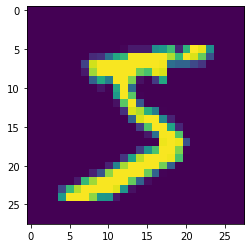

In [14]:
plt.imshow(numpy_img);

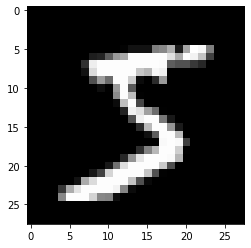

In [15]:
plt.imshow(numpy_img, cmap='gray');

Отрисовка заданной цифры:

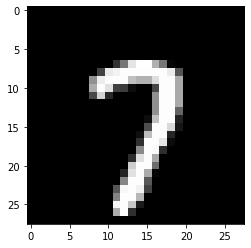

In [16]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.data[i].numpy(), cmap='gray');

Как итерироваться по данным с помощью `loader'`а? Очень просто:

In [17]:
for data in trainloader:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Со второй мы уже хорошенько разобрались в предыдущих ноутбуках по нейросетям, теперь мы испольузем именно `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

In [18]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [19]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки
        #   (for b/w images in_channels = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
            # input for this example (28, 28 , 1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
            # output of conv1 (24 = 28 - 5 + 1, 24, 6)    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            # output of pool (12, 12, 6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
            # output of conv2 (8 = 12 - 5 + 1, 8, 16)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        # why (4 * 4 * 16) ? 
        # 16 - number of shannels, 4*4 - size of the output in each of the
        #   16 feature maps after conv2D and pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        # break
        x = x.view(-1, 4 * 4 * 16)  # !!!
            # 0th element is the number of elements in the batch
            # we don't want to change it - so put -1 there (no change flag)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
net = SimpleConvNet()
net.to(device)

summary(model=net, input_size=(1, 28, 28)) # model = net.cuda(), batch_size=-1, device='cuda'

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [21]:
batch = next(iter(trainloader))
print(batch, type(batch))

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2314, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  .

In [22]:
batch[0]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2314, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [23]:
batch[0].to(device)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2314, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [24]:
net.forward(batch[0].to(device))

tensor([[ 0.0249, -0.0962, -0.0104,  0.0677,  0.1005,  0.0990,  0.0080, -0.0279,
         -0.1733, -0.0343],
        [ 0.0309, -0.0939, -0.0052,  0.0608,  0.1053,  0.0981,  0.0153, -0.0284,
         -0.1746, -0.0331],
        [ 0.0242, -0.0936, -0.0098,  0.0615,  0.1009,  0.0923,  0.0041, -0.0264,
         -0.1742, -0.0331],
        [ 0.0322, -0.0972, -0.0083,  0.0676,  0.1012,  0.1011,  0.0133, -0.0311,
         -0.1761, -0.0336]], device='cuda:0', grad_fn=<AddmmBackward>)

**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятный сходу 4 `*` 4 `*` 16. Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, `.Flatten()` всё делает за Вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в C * H * W нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [25]:
from tqdm.notebook import tqdm

In [26]:
# объявляем сеть
net = SimpleConvNet()
net = net.to(device)

In [27]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [28]:
%%time

cnt = 0
temp = 0
for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        cnt = i
        if i % 2000 == 1999:
          temp += 1

cnt, temp


CPU times: user 15.3 s, sys: 6.11 s, total: 21.4 s
Wall time: 38.7 s


[1,  2000] loss: 1.091
[1,  4000] loss: 0.418
[1,  6000] loss: 0.312
[1,  8000] loss: 0.267
[1, 10000] loss: 0.229
[1, 12000] loss: 0.207
[1, 14000] loss: 0.175



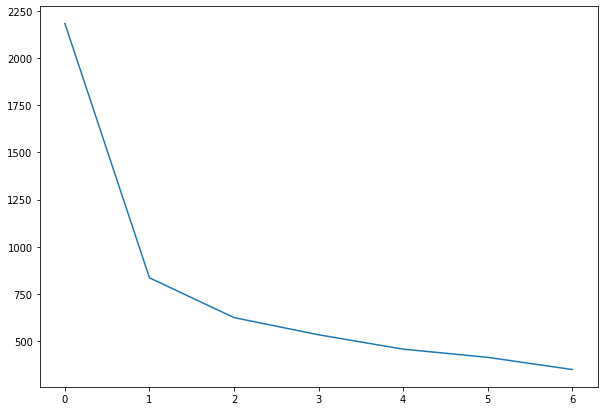

[2,  2000] loss: 0.149
[2,  4000] loss: 0.133
[2,  6000] loss: 0.126
[2,  8000] loss: 0.108
[2, 10000] loss: 0.114
[2, 12000] loss: 0.104
[2, 14000] loss: 0.098



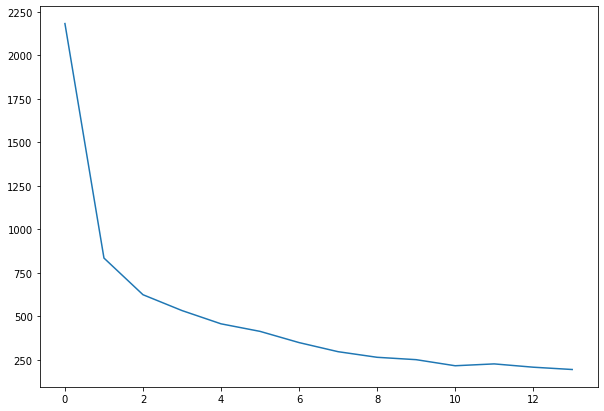


Обучение закончено
CPU times: user 2min 49s, sys: 14.4 s, total: 3min 3s
Wall time: 3min 23s


In [29]:
%%time

# record the losses
losses = []
# итерируемся
for epoch in tqdm(range(2)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # прибавим текущий loss к running loss на этих 2000 батчах
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss)
            # reset running loss to zero
            running_loss = 0.0

    plt.figure(figsize=(10,7))
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [39]:
print(f'Accuracy of the network on the {testloader.dataset.data.shape[0]} test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 97 %


А теперь протестируем на всём каждом классе:

In [31]:
%%time

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# do not compute gradients on this stage
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        y_pred = net(images)
        # choosing an actual prediction with argmax
        _, predicted = torch.max(y_pred, 1)
        
        c = (predicted == labels)
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 97 %
Accuracy of     3 : 97 %
Accuracy of     4 : 98 %
Accuracy of     5 : 95 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %
CPU times: user 6.94 s, sys: 1.04 s, total: 7.99 s
Wall time: 8.62 s


# CIFAR-10

### Задача 1

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

---

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [42]:
batch_size = 128

In [43]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Сами данные лежат в полях `trainloader.dataset.data` и `testloader.dataset.data`:

In [44]:
trainloader.dataset.data.shape

(50000, 32, 32, 3)

In [45]:
testloader.dataset.data.shape

(10000, 32, 32, 3)

horse
--------------------------------------------------------------------------------


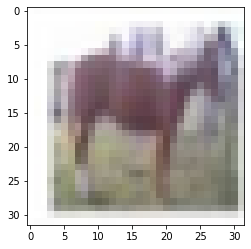

In [47]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i], cmap='gray') # image
print(classes[trainloader.dataset.targets[i]])       # label
print('-' * 80)

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 128), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Данные готовы, мы даже на них посмотрели.

### Задача 2

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [48]:
next(iter(trainloader))[0].shape

torch.Size([128, 3, 32, 32])

- batch_size=128
- 3 channels
- images 32*32

In [49]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super().__init__()
        # необходмо заранее знать, сколько каналов у картинки (было 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 128, 128)  # !!!
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        #(32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        #(28, 28) after conv1
        #(14,14) after pool
        x = self.pool(F.relu(self.conv2(x)))
        #(12, 12) after conv2
        #(6,6) after pool 
        #print(x.shape)
        x = x.view(-1, 6 * 6 * 128)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [50]:
net = MyConvNet()
net = net.to(device)

print(summary(model=net, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           4,864
         MaxPool2d-2           [-1, 64, 14, 14]               0
            Conv2d-3          [-1, 128, 12, 12]          73,856
         MaxPool2d-4            [-1, 128, 6, 6]               0
            Linear-5                  [-1, 128]         589,952
            Linear-6                   [-1, 64]           8,256
            Linear-7                   [-1, 10]             650
Total params: 677,578
Trainable params: 677,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.66
Params size (MB): 2.58
Estimated Total Size (MB): 3.25
----------------------------------------------------------------
None


In [51]:
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

Обучим:

[1,    50] loss: 2.225
[1,   100] loss: 1.979
[1,   150] loss: 1.868
[1,   200] loss: 1.786
[1,   250] loss: 1.715
[1,   300] loss: 1.660
[1,   350] loss: 1.603



[2,    50] loss: 1.554
[2,   100] loss: 1.529
[2,   150] loss: 1.497
[2,   200] loss: 1.488
[2,   250] loss: 1.492
[2,   300] loss: 1.475
[2,   350] loss: 1.442




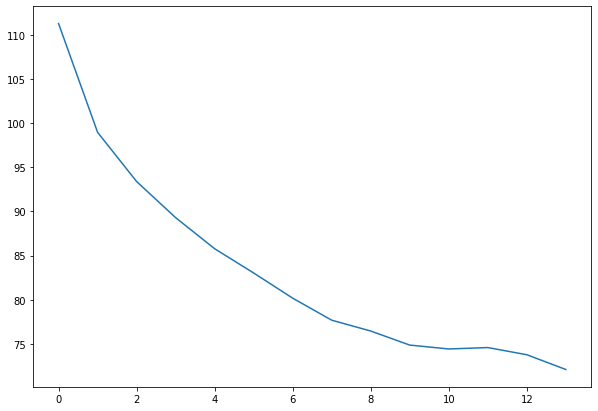

Обучение закончено
CPU times: user 10.4 s, sys: 2.81 s, total: 13.2 s
Wall time: 28.8 s


In [52]:
%%time

# record the losses
losses = []
# итерируемся
for epoch in tqdm(range(2)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 50 батчей
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            losses.append(running_loss)
            running_loss = 0.0

plt.figure(figsize=(10,7))
plt.plot(np.arange(len(losses)), losses)
plt.show()

print('Обучение закончено')

Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [53]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [54]:
print(f'Accuracy of the network on the {testloader.dataset.data.shape[0]} test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 48 %


А теперь протестируем на всём каждом классе:

In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        y_pred = net(images)#.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 64 %
Accuracy of  bird : 12 %
Accuracy of   cat : 32 %
Accuracy of  deer : 29 %
Accuracy of   dog : 33 %
Accuracy of  frog : 58 %
Accuracy of horse : 56 %
Accuracy of  ship : 62 %
Accuracy of truck : 35 %


Как думаете, этого достаточно?

### Задача 3  

Улучшите свёрточную нейросеть: поэкспериментируйте с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [60]:
next(iter(trainloader))[0].shape

torch.Size([128, 3, 32, 32])

(Ожидаемый результат -- скорее всего, сходу Вам не удастся выжать из Вашей сетки больше, чем ~70% accuracy (в среднем по всем классам). Если это что-то в этом районе - Вы хорошо постарались).

In [65]:
class ImprovedConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super().__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)

        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(2 * 2 * 256, 256)  # !!!
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        #(32, 32)
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        #(28, 28) after conv1: 28 = 32 - 5 + 1
        #(14, 14) after pool:  14 = 28 / 2
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        #(12, 12) after conv2: 12 = 14 - 3 + 1
        #(6, 6) after pool:    6 = 12 / 2
        x = self.pool(F.relu(self.conv3(x)))
        #(4, 4) after conv3:   4 = 6 - 3 + 1
        #(2, 2) after pool:    2 = 4 / 2

        #print(x.shape)
        #return


        x = x.view(-1, 2 * 2 * 256)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [66]:
net = ImprovedConvNet()
net = net.to(device)

print(summary(model=net, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
       BatchNorm2d-2           [-1, 64, 30, 30]             128
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 128, 13, 13]          73,856
       BatchNorm2d-5          [-1, 128, 13, 13]             256
         MaxPool2d-6            [-1, 128, 6, 6]               0
            Conv2d-7            [-1, 256, 4, 4]         295,168
         MaxPool2d-8            [-1, 256, 2, 2]               0
            Linear-9                  [-1, 256]         262,400
           Linear-10                  [-1, 128]          32,896
           Linear-11                   [-1, 64]           8,256
           Linear-12                   [-1, 10]             650
Total params: 675,402
Trainable params: 675,402
Non-trainable params: 0
-------------------------------

In [67]:
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

Обучим:

[1,    50] loss: 2.071
[1,   100] loss: 1.738
[1,   150] loss: 1.632
[1,   200] loss: 1.527
[1,   250] loss: 1.489
[1,   300] loss: 1.406
[1,   350] loss: 1.417



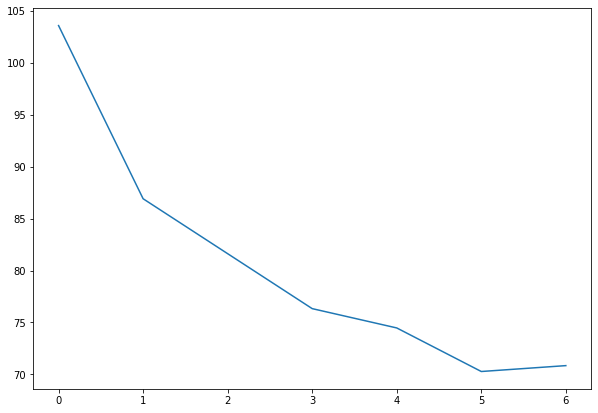

[2,    50] loss: 1.283
[2,   100] loss: 1.277
[2,   150] loss: 1.243
[2,   200] loss: 1.202
[2,   250] loss: 1.226
[2,   300] loss: 1.177
[2,   350] loss: 1.195



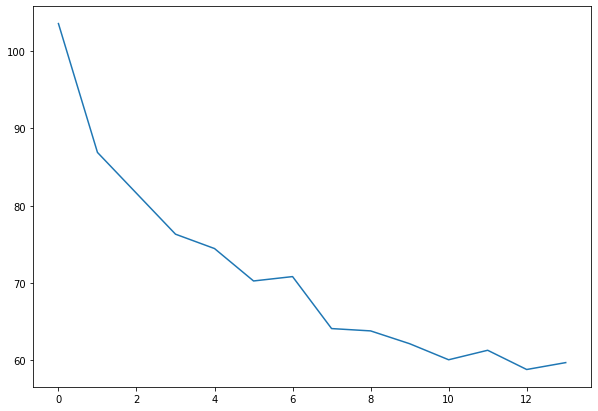

[3,    50] loss: 1.073
[3,   100] loss: 1.072
[3,   150] loss: 1.049
[3,   200] loss: 1.082
[3,   250] loss: 1.035
[3,   300] loss: 1.018
[3,   350] loss: 1.024



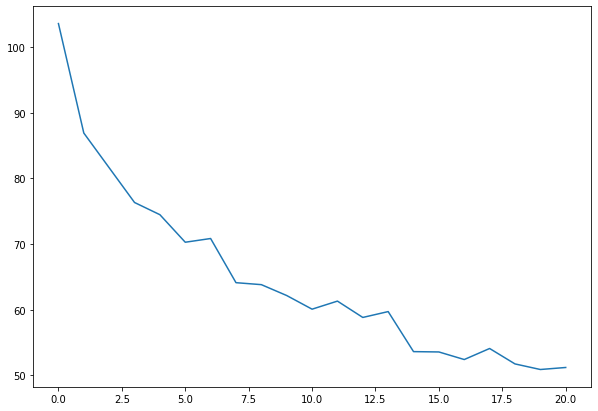

[4,    50] loss: 0.949
[4,   100] loss: 0.967
[4,   150] loss: 0.934
[4,   200] loss: 0.978
[4,   250] loss: 0.980
[4,   300] loss: 0.954
[4,   350] loss: 0.937



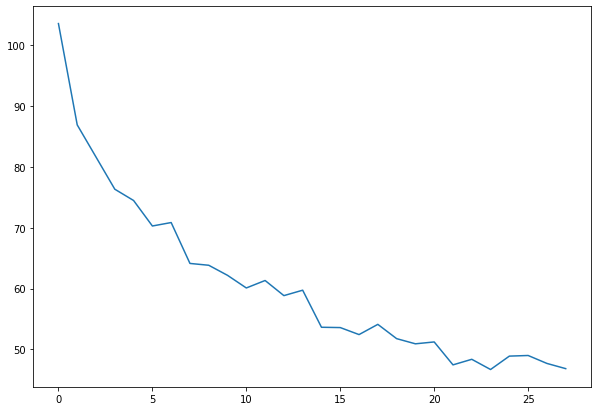

[5,    50] loss: 0.858
[5,   100] loss: 0.869
[5,   150] loss: 0.864
[5,   200] loss: 0.912
[5,   250] loss: 0.904
[5,   300] loss: 0.873
[5,   350] loss: 0.894



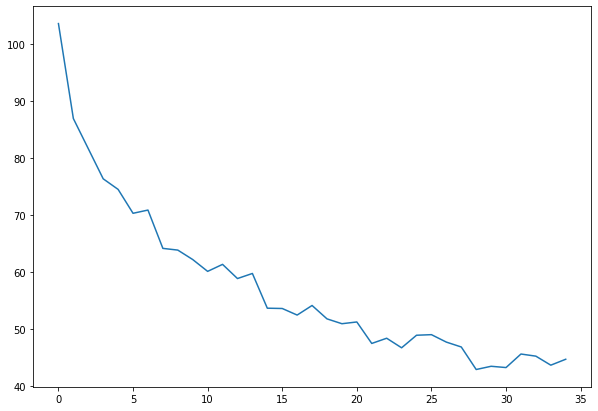

[6,    50] loss: 0.828
[6,   100] loss: 0.834
[6,   150] loss: 0.793
[6,   200] loss: 0.819
[6,   250] loss: 0.815
[6,   300] loss: 0.827
[6,   350] loss: 0.832



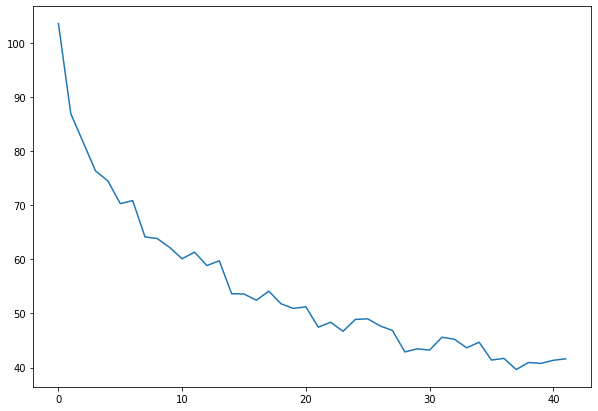

[7,    50] loss: 0.739
[7,   100] loss: 0.770
[7,   150] loss: 0.759
[7,   200] loss: 0.742
[7,   250] loss: 0.766
[7,   300] loss: 0.772
[7,   350] loss: 0.783



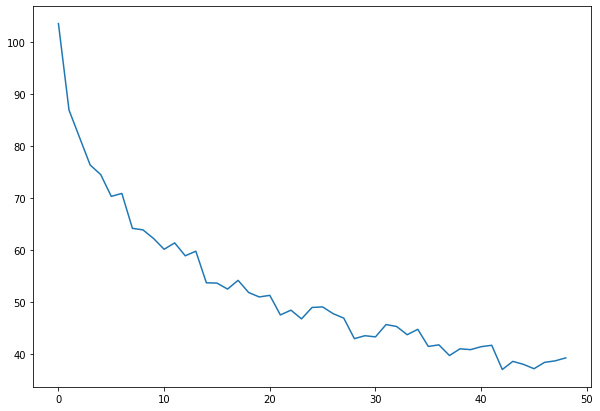

[8,    50] loss: 0.681
[8,   100] loss: 0.710
[8,   150] loss: 0.729
[8,   200] loss: 0.730
[8,   250] loss: 0.768
[8,   300] loss: 0.751
[8,   350] loss: 0.750



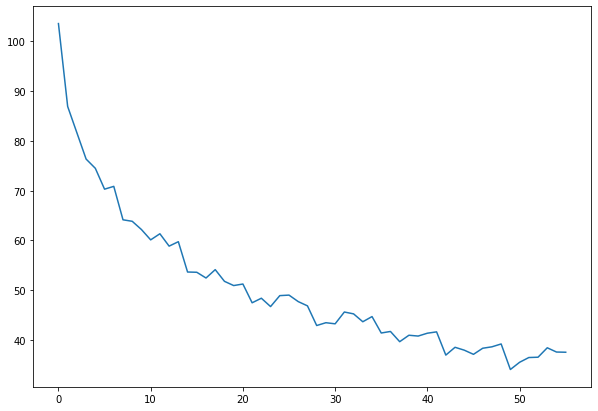

[9,    50] loss: 0.638
[9,   100] loss: 0.703
[9,   150] loss: 0.666
[9,   200] loss: 0.709
[9,   250] loss: 0.689
[9,   300] loss: 0.718
[9,   350] loss: 0.711



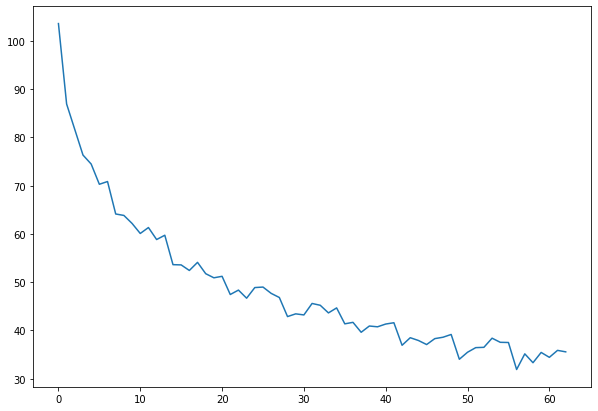

[10,    50] loss: 0.614
[10,   100] loss: 0.623
[10,   150] loss: 0.611
[10,   200] loss: 0.669
[10,   250] loss: 0.692
[10,   300] loss: 0.652
[10,   350] loss: 0.692



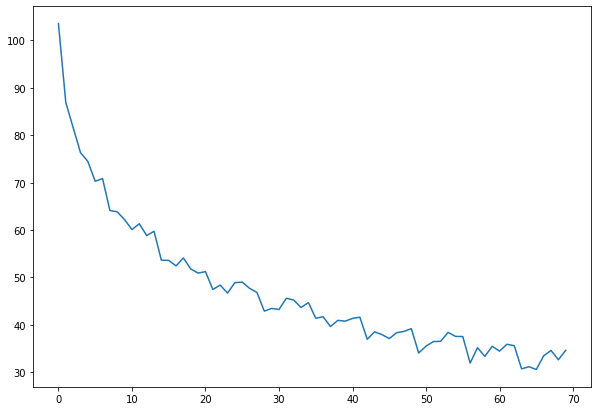


Обучение закончено
CPU times: user 1min 10s, sys: 10.4 s, total: 1min 20s
Wall time: 2min 36s


In [68]:
%%time

# record the losses
losses = []
# итерируемся
for epoch in tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 50 батчей
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            losses.append(running_loss)
            running_loss = 0.0

    plt.figure(figsize=(10,7))
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [69]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 70 %


А теперь ротестируем на всём каждом классе:

In [70]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        y_pred = net(images)#.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 85 %
Accuracy of  bird : 72 %
Accuracy of   cat : 64 %
Accuracy of  deer : 55 %
Accuracy of   dog : 48 %
Accuracy of  frog : 69 %
Accuracy of horse : 68 %
Accuracy of  ship : 90 %
Accuracy of truck : 74 %


<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M